In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.patches as mpatches

from scipy.stats import mannwhitneyu
import itertools

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
import sys 
sys.path.append('../../src')

from spaceoracle.oracles import BaseTravLR
from spaceoracle.plotting.cartography import Cartography


2025-08-11 12:11:10.085891: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

In [3]:
import json

with open('colors.json', 'r') as f:
    color_dict = json.load(f)

In [4]:
adata_control = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_visiumHD.h5ad')
adata_ko = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO4_visiumHD.h5ad')
adata_ko2 = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymphKO2_visiumHD.h5ad')

transferred = np.loadtxt('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/degs_lymph1_transferred.txt', dtype=str)
ko_transferred = np.loadtxt('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/degs_lymphKO4_transferred.txt', dtype=str)
ko2_transferred = np.loadtxt('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/degs_lymphKO2_transferred.txt', dtype=str)

len(transferred), len(ko_transferred), len(ko2_transferred)

(488, 632, 517)

In [5]:
# Remove the Tregs from the transferred list since the correct proportion is low

transferred = [cell for cell in transferred if adata_control.obs.loc[cell, 'cell_type'] != 'Treg']
ko_transferred = [cell for cell in ko_transferred if adata_ko.obs.loc[cell, 'cell_type'] != 'Treg']
ko2_transferred = [cell for cell in ko2_transferred if adata_ko2.obs.loc[cell, 'cell_type'] != 'Treg']
len(transferred), len(ko_transferred), len(ko2_transferred)


(176, 172, 198)

In [6]:
adata_control.X = adata_control.layers['normalized_count']
adata_ko.X = adata_ko.layers['normalized_count']
adata_ko2.X = adata_ko2.layers['normalized_count']

adata_control.obs['tissue'] = 'lymph1'
adata_ko.obs['tissue'] = 'lymphKO4'
adata_ko2.obs['tissue'] = 'lymphKO2'

In [7]:
lymph1_banksy_df = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/lymph1_visiumHD_banksy_annotated_zones.csv', index_col=0)
lymphko2_banksy_df = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/lymphKO2_visiumHD_banksy_annotated_zones.csv', index_col=0)
lymphko4_banksy_df = pd.read_csv('/ix/djishnu/alw399/SpaceOracle/notebooks/mouse_lymphnode_visiumHD/lymphKO4_visiumHD_banksy_annotated_zones.csv', index_col=0)

lymph1_banksy_df.index = lymph1_banksy_df.index.astype(str)
lymphko2_banksy_df.index = lymphko2_banksy_df.index.astype(str)
lymphko4_banksy_df.index = lymphko4_banksy_df.index.astype(str)


In [8]:
adata_control.obs['banksy_cluster'] = lymph1_banksy_df['banksy_cluster']
adata_ko.obs['banksy_cluster'] = lymphko4_banksy_df['banksy_cluster']
adata_ko2.obs['banksy_cluster'] = lymphko2_banksy_df['banksy_cluster']

adata_control.obs['1DER_cell_type'] = np.where(adata_control.obs.index.isin(transferred), adata_control.obs['cell_type'], 'NA')
adata_ko.obs['1DER_cell_type'] = np.where(adata_ko.obs.index.isin(ko_transferred), adata_ko.obs['cell_type'], 'NA')
adata_ko2.obs['1DER_cell_type'] = np.where(adata_ko2.obs.index.isin(ko2_transferred), adata_ko2.obs['cell_type'], 'NA')

adata_control.obs['1DER_cell_type'] = '1DER ' + adata_control.obs['1DER_cell_type'].astype(str)
adata_ko.obs['1DER_cell_type'] = '1DER ' + adata_ko.obs['1DER_cell_type'].astype(str)
adata_ko2.obs['1DER_cell_type'] = '1DER ' + adata_ko2.obs['1DER_cell_type'].astype(str)


In [9]:
def plot_spatial_zones(adata, transferred, save_path, th2=None):
    # Build dataframe with spatial coordinates and obs
    data = pd.concat(
        [pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names, columns=['x', 'y']),
         adata.obs],
        axis=1
    )

    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot all spots colored by banksy_cluster (background)
    sns.scatterplot(
        data=data,
        x='x', y='y',
        hue='banksy_cluster',
        palette=color_dict,
        alpha=0.3,
        s=10,
        ax=ax,
        legend=True
    )

    # Optionally plot Th2 cells if th2 is provided and not empty
    if th2 is not None and len(th2) > 0:
        data_th2 = data.loc[th2].copy()
        data_th2['cell_type'] = 'Th2'
        sns.scatterplot(
            data=data_th2,
            x='x', y='y',
            hue='cell_type',
            palette={'Th2': color_dict.get('Th2', '#000000')},
            s=40,
            ax=ax,
            legend=True,
            edgecolor='black',
            linewidth=0.5,
            alpha=0.4
        )

    # Plot transferred cells
    data_trans = data.loc[transferred].copy()
    data_trans['1DER_cell_type'] = data_trans['1DER_cell_type'].astype('category')
    data_trans['1DER_cell_type'] = data_trans['1DER_cell_type'].cat.remove_unused_categories()
    scatter = sns.scatterplot(
        data=data_trans,
        x='x', y='y',
        hue='1DER_cell_type',
        palette=color_dict,
        alpha=1,
        edgecolor='black',
        linewidth=0.5,
        s=30,
        ax=ax,
        legend='brief'
    )

    # Clean up axes
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Build legend: show only relevant categories
    handles, labels = ax.get_legend_handles_labels()
    # Get unique categories for legend
    unique_banksy = pd.Series(data['banksy_cluster'].unique()).astype(str)
    unique_1der = pd.Series(data_trans['1DER_cell_type'].unique()).astype(str)
    legend_labels = list(unique_banksy) + list(unique_1der)
    if th2 is not None and len(th2) > 0:
        legend_labels.append('Th2')

    filtered_handles = []
    filtered_labels = []
    for handle, label in zip(handles, labels):
        if label in legend_labels:
            filtered_handles.append(handle)
            filtered_labels.append(label)

    ax.legend(filtered_handles, filtered_labels, loc='center left', bbox_to_anchor=(1.1, 0.5), borderaxespad=0, title=None)
    plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True, format='svg')
    plt.show()

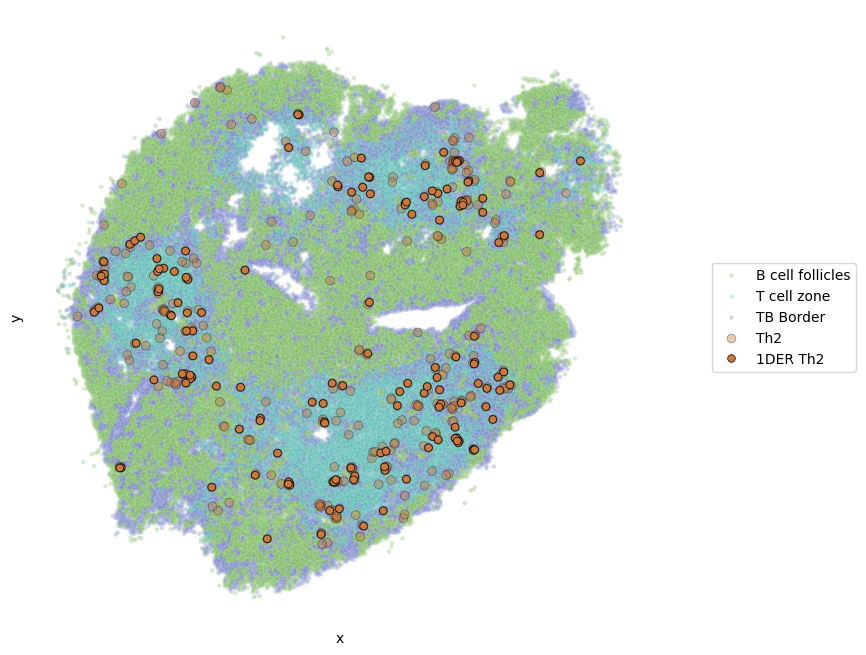

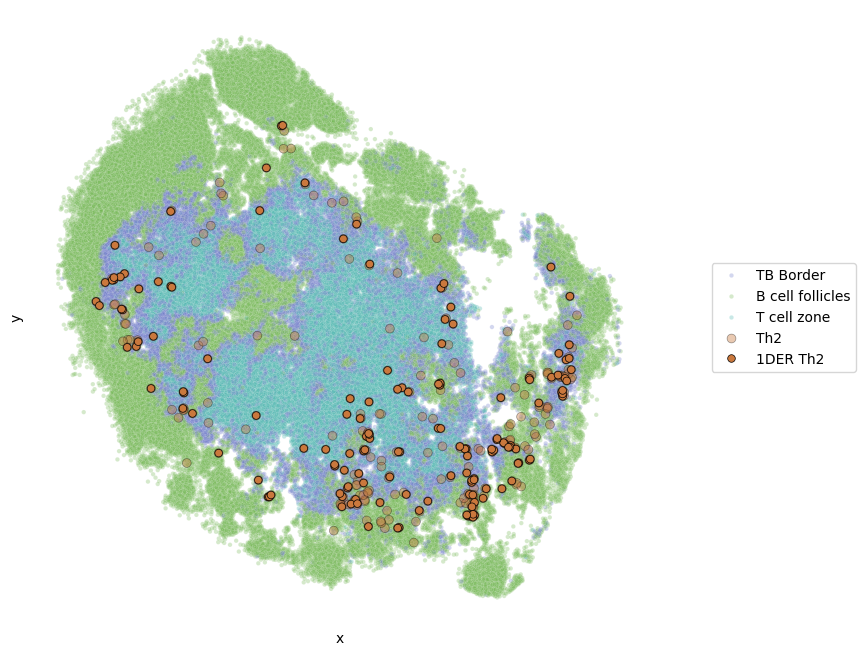

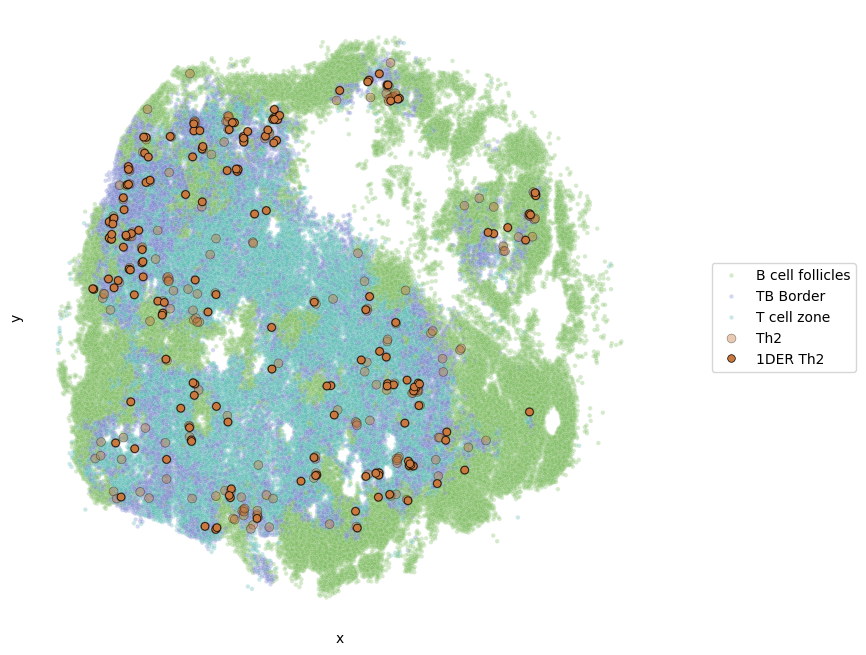

In [10]:
plot_spatial_zones(
    adata_control, adata_control.obs[adata_control.obs['1DER_cell_type'].isin(['1DER Th2'])].index, 
    'figures/mouse_lymph1_1DER_locations.svg', th2=adata_control[adata_control.obs.cell_type == 'Th2'].obs_names
)
plot_spatial_zones(
    adata_ko, adata_ko.obs[adata_ko.obs['1DER_cell_type'].isin(['1DER Th2'])].index, 
    'figures/mouse_lymphKO4_1DER_locations.svg', th2=adata_ko[adata_ko.obs.cell_type == 'Th2'].obs_names
)
plot_spatial_zones(
    adata_ko2, adata_ko2.obs[adata_ko2.obs['1DER_cell_type'].isin(['1DER Th2'])].index, 
    'figures/mouse_lymphKO2_1DER_locations.svg', th2=adata_ko2[adata_ko2.obs.cell_type == 'Th2'].obs_names
)

In [11]:
display(adata_control[adata_control.obs['1DER_cell_type'].isin(['1DER Th2'])].obs['banksy_cluster'].value_counts())
display(adata_ko[adata_ko.obs['1DER_cell_type'].isin(['1DER Th2'])].obs['banksy_cluster'].value_counts())
display(adata_ko2[adata_ko2.obs['1DER_cell_type'].isin(['1DER Th2'])].obs['banksy_cluster'].value_counts())


banksy_cluster
T cell zone         77
TB Border           60
B cell follicles    16
Name: count, dtype: int64

banksy_cluster
TB Border           65
T cell zone         48
B cell follicles    36
Name: count, dtype: int64

banksy_cluster
T cell zone         102
TB Border            43
B cell follicles     19
Name: count, dtype: int64

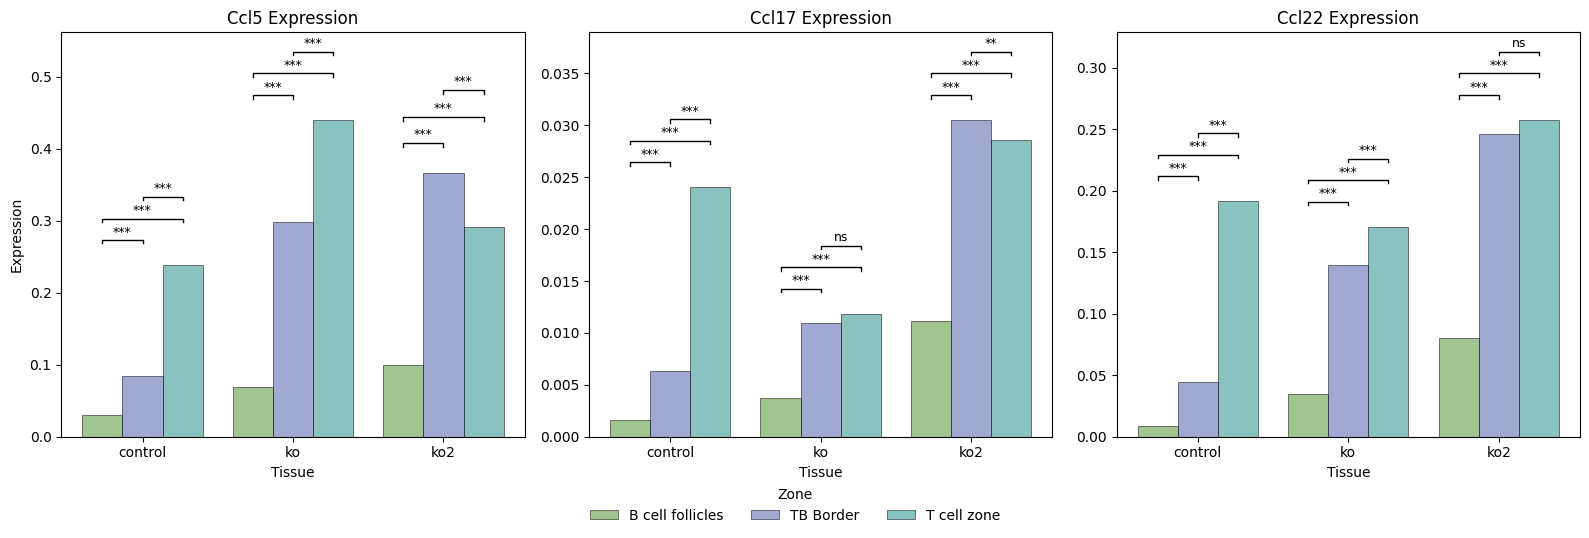

In [12]:
df_control = pd.concat([adata_control.to_df(), adata_control.obs[['cell_type', 'banksy_cluster']]], axis=1)
df_ko = pd.concat([adata_ko.to_df(), adata_ko.obs[['cell_type', 'banksy_cluster']]], axis=1)
df_ko2 = pd.concat([adata_ko2.to_df(), adata_ko2.obs[['cell_type', 'banksy_cluster']]], axis=1)

df_control['tissue'] = 'control'
df_ko['tissue'] = 'ko'
df_ko2['tissue'] = 'ko2'

df_all = pd.concat([df_control, df_ko, df_ko2], axis=0)
zone_order = ['B cell follicles', 'TB Border', 'T cell zone']
df_all['banksy_cluster'] = pd.Categorical(df_all['banksy_cluster'], categories=zone_order, ordered=True)
df_melted = df_all.melt(
    id_vars=['banksy_cluster', 'tissue'],
    value_vars=['Ccl17', 'Ccl22', 'Ccl21a', 'Ccl5'],
    var_name='Gene',
    value_name='Expression'
)

genes = ['Ccl5', 'Ccl17', 'Ccl22']
fig, axes = plt.subplots(1, len(genes), figsize=(16, 5), sharey=False)

def add_significance(ax, x1, x2, y, p, h_rel=0.02, star_offset_rel=0.01):
    y_min, y_max = ax.get_ylim()
    y_range = y_max - y_min
    h = h_rel * y_range
    star_offset = star_offset_rel * y_range
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, c='k', clip_on=False)
    if p < 0.001:
        stars = '***'
    elif p < 0.01:
        stars = '**'
    elif p < 0.05:
        stars = '*'
    else:
        stars = 'ns'
    ax.text((x1 + x2) * 0.5, y + h + star_offset, stars, ha='center', va='bottom', color='k', fontsize=9, clip_on=False)

for i, gene in enumerate(genes):
    ax = axes[i]
    data_gene = df_melted[df_melted['Gene'] == gene]
    # Compute mean expression per group (group by tissue, color by zone)
    mean_df = (
        data_gene
        .groupby(['tissue', 'banksy_cluster'], observed=True)['Expression']
        .mean()
        # .sum()
        .reset_index()
    )
    # Ensure banksy_cluster is categorical and sorted in the desired order
    mean_df['banksy_cluster'] = pd.Categorical(mean_df['banksy_cluster'], categories=zone_order, ordered=True)
    # Barplot of mean expression: x = tissue, hue = banksy_cluster (zone)
    sns.barplot(
        data=mean_df,
        x='tissue',
        y='Expression',
        hue='banksy_cluster',
        palette=color_dict,
        ax=ax,
        edgecolor='black',
        linewidth=0.5,
        dodge=True,
        alpha=0.7,
        hue_order=zone_order
    )
    # # Overlay stripplot of nonzero values
    # sns.stripplot(
    #     data=data_gene[data_gene['Expression'] > 0],
    #     x='tissue',
    #     y='Expression',
    #     hue='banksy_cluster',
    #     palette=color_dict,
    #     dodge=True,
    #     ax=ax,
    #     size=2,
    #     jitter=True,
    #     marker='o',
    #     linewidth=0,
    #     alpha=0.5,
    #     legend=False,
    #     hue_order=zone_order
    # )
    ax.set_title(f'{gene} Expression')
    ax.set_xlabel('Tissue')
    if i == 0:
        ax.set_ylabel('Expression')
    else:
        ax.set_ylabel('')

    # Add significance bars for each tissue between zones
    tissues = mean_df['tissue'].unique()
    zones = zone_order  # Use the specified order
    width = 0.8 / len(zones)  # width of each bar

    # For each tissue, compare all pairs of zones
    for j, tissue in enumerate(tissues):
        tissue_data = data_gene[data_gene['tissue'] == tissue]
        pairs = list(itertools.combinations(zones, 2))
        # Find the max y for this tissue's bars
        y_bars = mean_df[mean_df['tissue'] == tissue]['Expression'].values
        if len(y_bars) == 0:
            continue
        y_max = np.max(y_bars)
        # Set a small, fixed offset for annotation stacking, relative to y-range
        y_min_ax, y_max_ax = ax.get_ylim()
        y_range = y_max_ax - y_min_ax
        y_offset = max(y_range * 0.05, 0.02 * y_range)
        # For each pair, stack significance bars closely above the bars
        for k, (zone1, zone2) in enumerate(pairs):
            vals1 = tissue_data[tissue_data['banksy_cluster'] == zone1]['Expression']
            vals2 = tissue_data[tissue_data['banksy_cluster'] == zone2]['Expression']
            # Only test if both groups have >0 nonzero values
            if (vals1 > 0).sum() > 0 or (vals2 > 0).sum() > 0:
                try:
                    stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
                except ValueError:
                    p = 1.0
            else:
                p = 1.0
            # Calculate x positions for bars
            zone_idx1 = zones.index(zone1)
            zone_idx2 = zones.index(zone2)
            x1 = j - 0.4 + width/2 + zone_idx1*width
            x2 = j - 0.4 + width/2 + zone_idx2*width
            y = y_max + (k+1) * y_offset * 1.3
            add_significance(ax, x1, x2, y, p, h_rel=0.01, star_offset_rel=0.005)

    # Remove all legends from axes
    ax.legend_.remove() if ax.get_legend() is not None else None

# Move the legend below the subplots, off of the plot
handles, labels = axes[-1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend_labels = [z for z in zone_order if z in by_label]
legend_handles = [by_label[z] for z in legend_labels]
fig.subplots_adjust(bottom=0.22)  # Make space for legend below
fig.legend(
    legend_handles,
    legend_labels,
    title='Zone',
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),
    ncol=3,
    frameon=False
)

plt.tight_layout()  # leave space at bottom for legend
plt.savefig('figures/mouse_lymph_visiumHD_ligand_gradient.svg', dpi=300, bbox_inches='tight', transparent=True, format='svg')
plt.show()

In [13]:
goi = 'Ccr4'

simulated_gex = [
    pd.read_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1{part}_visiumHD/{goi}_4n_0x_Cd4.parquet')
    for part in ['a', 'b', 'c', 'd']]
simulated_gex = pd.concat(simulated_gex, axis=0)

### KO localization prediction

In [14]:
import sys 
sys.path.append('../../src')

from spaceoracle.oracles import BaseTravLR
from spaceoracle.plotting.cartography import Cartography

In [15]:
adata_ = adata_control[(adata_control.obs.cell_type == 'Th2') & (adata_control.obs.index.isin(transferred))]
chart = Cartography(adata_, color_dict)

In [16]:
delta_X = (simulated_gex.loc[adata_.obs.index] - chart.unperturbed_expression).values
gene_mtx = chart.unperturbed_expression.values
P = chart.compute_transition_probabilities(
    delta_X, 
    embedding=chart.adata.obsm['X_umap'],
    n_neighbors=130)

In [17]:
chart.get_transition_annot(
    P,
    allowed_fates=chart.adata.obs['banksy_cluster'].unique(), 
    thresh=0, 
    annot='banksy_cluster'
)

100%|██████████| 60/60 [00:01<00:00, 34.57it/s]


source ct TB Border Counter({'TB Border': 37, 'B cell follicles': 23}) 0.003826257911160839 0.0028029577534916723


100%|██████████| 16/16 [00:00<00:00, 87.38it/s]


source ct B cell follicles Counter({'B cell follicles': 13, 'TB Border': 3}) 0.003787432282592775 0.0


100%|██████████| 77/77 [00:00<00:00, 83.80it/s]


source ct T cell zone Counter({'TB Border': 66, 'B cell follicles': 11}) 0.004627621454226268 0.0010686731793825262


In [20]:
import plotly.graph_objects as go
import numba
numba.set_num_threads(1)

def plot_sankey_from_counts(df, counts, title, savepath, color_dict=None):
    counts = counts.sort_index(axis=0).sort_index(axis=1)

    left_labels = sorted(list(counts.index))
    right_labels = sorted(list(counts.columns))

    # Create unique node keys for left and right, but display the same label
    left_keys = [f"{label}__from" for label in left_labels]
    right_keys = [f"{label}__to" for label in right_labels]
    all_keys = left_keys + right_keys

    all_labels = left_labels + right_labels

    # Map from original label to unique key
    left_label_to_key = {label: f"{label}__from" for label in left_labels}
    right_label_to_key = {label: f"{label}__to" for label in right_labels}

    # Map unique keys to node indices
    left_key_to_idx = {key: i for i, key in enumerate(left_keys)}
    right_key_to_idx = {key: i + len(left_keys) for i, key in enumerate(right_keys)}
    key_to_idx = {**left_key_to_idx, **right_key_to_idx}

    # Node colors
    if color_dict is not None:
        node_colors = [color_dict.get(label, "#1f77b4") for label in all_labels]
    else:
        node_colors = "blue"

    sources = []
    targets = []
    values = []
    link_colors = []

    for src in left_labels:
        for tgt in right_labels:
            val = counts.loc[src, tgt] if (src in counts.index and tgt in counts.columns) else 0
            if val > 0:
                src_key = left_label_to_key[src]
                tgt_key = right_label_to_key[tgt]
                sources.append(key_to_idx[src_key])
                targets.append(key_to_idx[tgt_key])
                values.append(val)
                # Use color_dict for link color if available, else default rgba
                if color_dict is not None:
                    base_color = color_dict.get(src, "#1f77b4")
                    if base_color.startswith("#") and len(base_color) == 7:
                        r = int(base_color[1:3], 16)
                        g = int(base_color[3:5], 16)
                        b = int(base_color[5:7], 16)
                        link_colors.append(f"rgba({r},{g},{b},0.4)")
                    else:
                        link_colors.append("rgba(31,119,180,0.4)")
                else:
                    link_colors.append("rgba(31,119,180,0.4)")

    # Set node x positions: left column at 0, right column at 1
    node_x = [0.0] * len(left_keys) + [1.0] * len(right_keys)

    fig = go.Figure(data=[go.Sankey(
        # arrangement="snap",
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=all_labels,
            color=node_colors,
            x=node_x,
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors
        )
    )])

    fig.update_layout(
        title_text=title,
        font_size=10,
        autosize=False,
        width=500,
        height=400,
        margin=dict(l=10, r=10, t=40, b=10)
    )

    fig.write_image(savepath, format=savepath.split('.')[-1], engine='orca')
    fig.show()

In [21]:
chart.adata.obs['banksy_cluster'] = chart.adata.obs['banksy_cluster'].astype('category')
chart.adata.obs['banksy_cluster'] = chart.adata.obs['banksy_cluster'].cat.remove_unused_categories()
chart.adata.obs['transition'] = chart.adata.obs['transition'].astype('category')
chart.adata.obs['transition']=chart.adata.obs['transition'].cat.remove_unused_categories()

df = chart.adata.obs[['banksy_cluster', 'transition']].copy()
counts = df.groupby(['banksy_cluster', 'transition']).size().unstack(fill_value=0)

plot_sankey_from_counts(
    df, counts, 
    f"Th2 Transitions between zones from Ccr4 KO\nin Day 5 VisiumHD Mouse Lymph Node", 
    f'figures/mouse_lymph1_{goi}KO_transitions_Th2.svg', 
    color_dict=color_dict
)

# if counts.empty:
#     # Create empty DataFrame with same index and columns
#     counts = pd.DataFrame(0, index=counts.index, columns=counts.columns)
# elif len(counts.index) != len(counts.columns):
#     # Add missing rows/columns with zeros
#     all_labels = sorted(set(counts.index) | set(counts.columns))
#     counts = counts.reindex(index=all_labels, columns=all_labels, fill_value=0)

# plt.figure(figsize=(3,3), dpi=300)
# sns.heatmap(
#     counts,
#     annot=True,
#     fmt='d',  # Changed to integer format
#     cmap='Blues',
#     linewidths=0.5,
#     linecolor='white',
#     cbar=False,
#     square=True,
#     annot_kws={"size": 6}
# )

# plt.title(f"Th2 Transitions between zones from Ccr4 KO\nin Day 5 VisiumHD Mouse Lymph Node", fontsize=8)
# plt.xlabel("Transition Label", fontsize=6)
# plt.ylabel("Original", fontsize=6)
# plt.xticks(rotation=45, ha='right', fontsize=6)
# plt.yticks(rotation=0, fontsize=6)

# plt.tight_layout()
# plt.savefig(f'figures/mouse_lymph1_{goi}KO_transitions_Th2.svg', format='svg', dpi=300, bbox_inches='tight', transparent=True)
# plt.show()

Retrying in 8.20 seconds due to HTTPConnectionPool(host='localhost', port=35083): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f20f34ffe20>: Failed to establish a new connection: [Errno 111] Connection refused'))...


### Radar plots

In [ ]:
from spaceoracle.plotting.cartography import Cartography
from spaceoracle.virtual_tissue import VirtualTissue

lymph = VirtualTissue(
    adata = adata,
    annot = 'cell_type',
    betadatas_path = '/ix/djishnu/shared/djishnu_kor11/lasso_runs/slideseq_mouse_lymphnode',
    ko_path = '/ix/djishnu/shared/djishnu_kor11/genome_screens/slideseq_mouse_lymphnode',
    color_dict=color_dict
)

In [ ]:
ligands = ['Il2', 'Il15', 'Il4', 'Cxcl13', 'Ccl5', 'Lgals9']
receptors = ['Il2ra', 'Cxcr4', 'Ccr4', 'Il4ra', 'Il6st', 'Cxcr5']
tf = ['Gata3', 'Prdm1', 'Pax5', 'Foxp3', 'Bcl6', 'Stat4']
randoms = ['Gata3', 'Cux2', 'Pten', 'Fosl2', 'Zkscan3', 'Tfcp2']


In [ ]:
%matplotlib inline
lymph.plot_radar(genes=ligands, 
    cache_path='../../notebooks/mouse_lymphnode_slideseq/', 
    figsize=(10, 4),
    dpi=120,
)
plt.title('Ligands\n\n', fontweight='bold')
plt.savefig('./figures/spider_plot_ligands.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()

lymph.plot_radar(genes=receptors, 
    cache_path='../../notebooks/mouse_lymphnode_slideseq/', 
    figsize=(10, 4),
    dpi=120,
)
plt.title('Receptors\n\n', fontweight='bold')
plt.savefig('./figures/spider_plot_receptors.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()

lymph.plot_radar(genes=tf, 
    cache_path='../../notebooks/mouse_lymphnode_slideseq/', 
    figsize=(10, 4),
    dpi=120,
)
plt.title('Transcription factors\n\n', fontweight='bold')
plt.savefig('./figures/spider_plot_tf.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()

### Altered interactions?

In [20]:
goi = 'Ccr4'

simulated_gex = [
    pd.read_parquet(f'/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymph1{part}_visiumHD/{goi}_4n_0x_1der.parquet')
    for part in ['a', 'b', 'c', 'd']]
simulated_gex = pd.concat(simulated_gex, axis=0)
simulated_gex = simulated_gex.loc[adata_control.obs.index]

In [21]:
def compute_delta_ko_zone(gex_ko, adata_ko, adata_control, epsilon=1e-8):
    delta_ko_zone = {}
    for zone in adata_ko.obs['banksy_cluster'].unique():
        gex_ko_zone = gex_ko[adata_ko.obs['banksy_cluster'] == zone]
        control_zone = adata_control[adata_control.obs['banksy_cluster'] == zone].to_df(layer='normalized_count').mean(axis=0)
        delta_ko_zone[zone] = ((gex_ko_zone.mean(axis=0) - control_zone) / (control_zone + epsilon)).abs().mean()
    return delta_ko_zone

def plot_delta_zone_barplot(delta_zone, color_dict, title, save_path='figures/mouse_lymph1_Ccr4KO_delta_zone_barplot.svg'):
    fig, ax = plt.subplots(figsize=(5, 5))

    # Convert the dictionary to a DataFrame
    delta_zone_df = pd.DataFrame(list(delta_zone.items()), columns=['banksy_cluster', 'Mean Relative Change'])

    order = ['B cell follicles', 'TB Border', 'T cell zone']
    delta_zone_df['banksy_cluster'] = pd.Categorical(delta_zone_df['banksy_cluster'], categories=order, ordered=True)

    sns.barplot(
        data=delta_zone_df,
        x='banksy_cluster',
        y='Mean Relative Change',
        ax=ax,
        palette=color_dict,
        edgecolor='black'
    )

    ax.set_ylabel('Mean Relative Change', fontsize=10)
    ax.set_xlabel('banksy_cluster', fontsize=10)
    ax.set_title(title, fontsize=10)
    ax.tick_params(axis='x', labelrotation=30, labelsize=9)
    ax.tick_params(axis='y', labelsize=9)


    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.3f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=8, xytext=(0, 3), textcoords='offset points')
    y_max = ax.get_ylim()[1]
    ax.set_ylim(0, y_max + 5)

    plt.tight_layout()
    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()



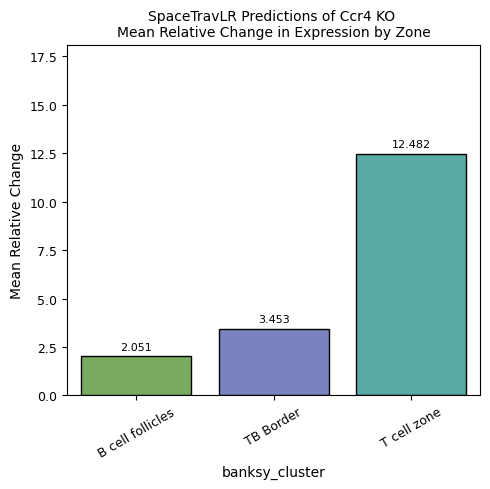

In [22]:
delta_zone = compute_delta_ko_zone(simulated_gex, adata_control, adata_control)
plot_delta_zone_barplot(delta_zone, color_dict, 
                        title='SpaceTravLR Predictions of Ccr4 KO \nMean Relative Change in Expression by Zone',
                        save_path='figures/mouse_lymph1_Ccr4KO_delta_zone_barplot.svg')

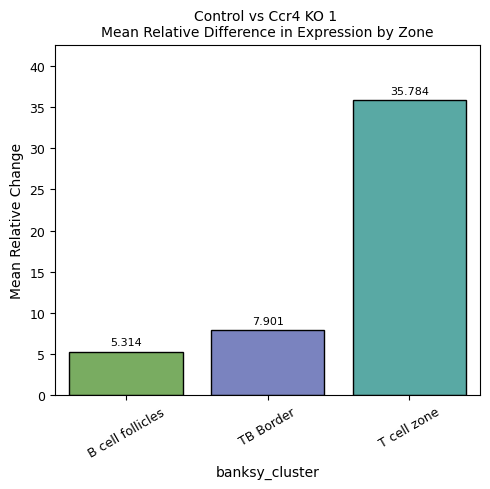

In [23]:
delta_zone = compute_delta_ko_zone(adata_ko.to_df(layer='normalized_count'), adata_ko, adata_control)
plot_delta_zone_barplot(delta_zone, color_dict, 
                        title='Control vs Ccr4 KO 1 \nMean Relative Difference in Expression by Zone',
                        save_path='figures/mouse_lymphKO4_Ccr4KO_delta_zone_barplot.svg')

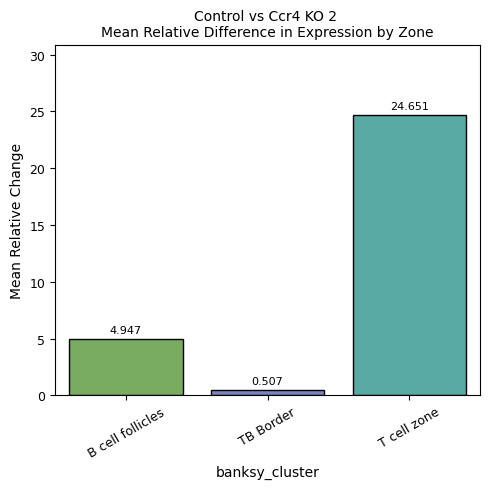

In [24]:
delta_zone = compute_delta_ko_zone(adata_ko2.to_df(layer='normalized_count'), adata_ko2, adata_control)
plot_delta_zone_barplot(delta_zone, color_dict, 
                        title='Control vs Ccr4 KO 2 \nMean Relative Difference in Expression by Zone',
                        save_path='figures/mouse_lymphKO2_Ccr4KO_delta_zone_barplot.svg')

### Correlation of Transferred Th2

In [39]:
def plot_corr(gex_control, gex_sim, gex_ko, top_genes, n_genes, corr_type='pearson', use_delta=False, 
title='Experimental vs In Silico Predictions \nfor all DEGs', save_path='spearman_corr.svg'):

    changed_genes = top_genes['names'].values

    if 'Ccr4' in changed_genes:
        changed_genes = changed_genes[changed_genes != 'Ccr4']

    gex_control = gex_control[changed_genes]
    gex_sim = gex_sim[changed_genes]
    gex_ko = gex_ko[changed_genes]

    if not use_delta:
        gex_control = gex_control.mean(axis=0)
        gex_sim = gex_sim.mean(axis=0)
        gex_ko = gex_ko.mean(axis=0)
    

    if corr_type == 'pearson':
        corr = pearsonr(gex_ko, gex_sim).statistic
        corr_control = pearsonr(gex_ko, gex_control).statistic
    elif corr_type == 'spearman':
        corr = spearmanr(gex_ko, gex_sim).statistic
        corr_control = spearmanr(gex_ko, gex_control).statistic
    
    correlations = {'SpaceTravLR': corr, 'Unperturbed': corr_control}

    plt.bar(correlations.keys(), correlations.values(), linewidth=2, 
        edgecolor='black', color=['salmon', 'deepskyblue', 'grey'])

    plt.ylabel(f'{corr_type.capitalize()} Correlation Coefficient')
    # plt.title(r'experimental vs $\it{in\ silico}$ predictions' + f'\nfor top ' + str(n_genes) + ' genes')
    # plt.title(r'experimental vs $\it{in\ silico}$ predictions' + f'\nfor all DEGs')
    plt.title(title)

    for i, (key, value) in enumerate(correlations.items()):
        plt.text(i, max(value, 0) - 0.1, f'{value:.2f}', ha='center', 
            va='center', color='black', fontweight='bold')
        
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.savefig(save_path, transparent=True, bbox_inches='tight', dpi=300, format='svg')
    plt.show()


In [68]:
adata_control = adata_control[(adata_control.obs.index.isin(transferred)) & (adata_control.obs.cell_type.isin(['Th2', 'Tfh']))]
adata_ko = adata_ko[(adata_ko.obs.index.isin(ko_transferred)) & (adata_ko.obs.cell_type.isin(['Th2', 'Tfh']))]
adata_ko2 = adata_ko2[(adata_ko2.obs.index.isin(ko2_transferred)) & (adata_ko2.obs.cell_type.isin(['Th2', 'Tfh']))]

gex_ko = adata_ko.to_df(layer='normalized_count')
gex_ko2 = adata_ko2.to_df(layer='normalized_count')

gex_control = adata_control.to_df(layer='imputed_count')
gex_sim = simulated_gex.loc[adata_control.obs.index]
delta_gex = gex_sim - gex_control
gex_sim = adata_control.to_df(layer='normalized_count') + delta_gex

In [69]:
adata_full = sc.concat([adata_control, adata_ko, adata_ko2], axis=0)
sc.tl.rank_genes_groups(adata_full, 'tissue', method='wilcoxon', reference='lymph1')
degs_df = sc.get.rank_genes_groups_df(adata_full, group='lymphKO2')
degs_df2 = sc.get.rank_genes_groups_df(adata_full, group='lymphKO4')

In [70]:
degs_df = degs_df[degs_df['pvals'] < 0.05]
degs_df2 = degs_df2[degs_df2['pvals'] < 0.05]
top_degs_df = degs_df.sort_values(by='logfoldchanges', ascending=False)
top_degs_df2 = degs_df2.sort_values(by='logfoldchanges', ascending=False)


In [71]:
top_degs_df = top_degs_df[top_degs_df['names'].isin(top_degs_df2['names'])]
top_degs_df2 = top_degs_df2[top_degs_df2['names'].isin(top_degs_df2['names'])]

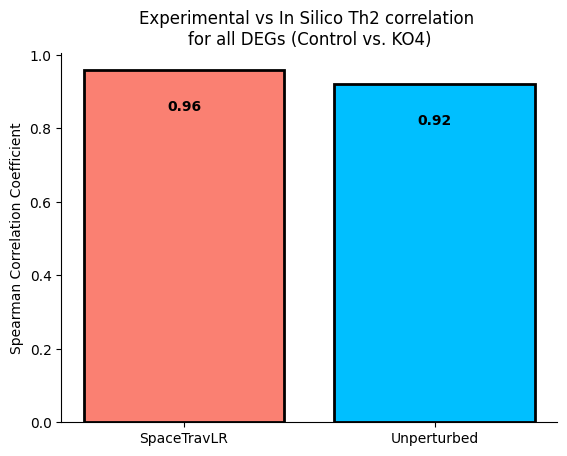

In [72]:
# plot_corr(gex_control, gex_sim, gex_ko, top_degs_df, n_genes=1500, corr_type='pearson')
plot_corr(gex_control, gex_sim, gex_ko, top_degs_df, n_genes=gex_control.shape[1], corr_type='spearman', 
          title='Experimental vs In Silico Th2 correlation \nfor all DEGs (Control vs. KO4)',
          save_path='figures/spearman_1der_all_degs_control_vs_ko4.svg')

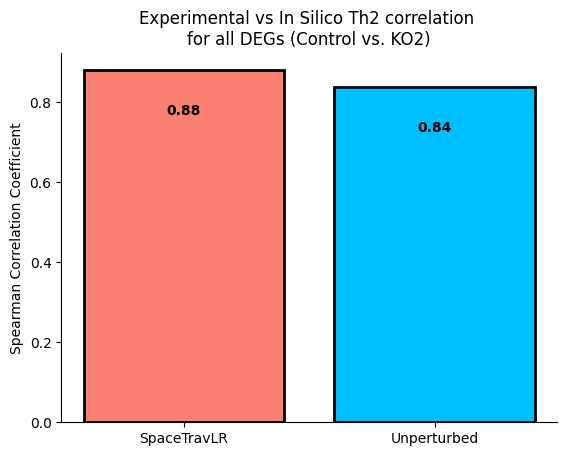

In [73]:
# plot_corr(gex_control, gex_sim, gex_ko2, top_degs_df2, n_genes=1500, corr_type='pearson')
plot_corr(gex_control, gex_sim, gex_ko2, top_degs_df2, n_genes=gex_control.shape[1], corr_type='spearman',
          title='Experimental vs In Silico Th2 correlation \nfor all DEGs (Control vs. KO2)',
          save_path='figures/spearman_1der_all_degs_control_vs_ko2.svg')